In [102]:
# Python relies on libraries

# import a library for array manipulations
import numpy as np

# import a library for plotting
%matplotlib inline
import matplotlib.pyplot as plt

# import a library to load files
import scipy.io as sio

# library to load csv files
import csv

In [106]:
# load the csv file to python
data = csv.reader(open('H_eeg.csv','rb'))

In [107]:
print 'The type of data is: ', type(data)

# skip the header
header = data.next()

# innitialize a variable to keep our data
raw_data=[]
for row in data:
        raw_data.append(row)

# transpose the variable
raw_data = np.asarray(raw_data).T

# in raw data, the stim triggers (codes) are in column 19
stim_triggs = raw_data[19]

nchan = 14
# select eeg channels
raw_data = raw_data[2:2+nchan]

print 'the shape of raw_data is: ', raw_data.shape
print 'the shape of stim_triggs is:', stim_triggs.shape

The type of data is:  <type '_csv.reader'>
the shape of data is:  (14, 40704)
the shape of stim_triggs is: (40704,)


In [109]:
# Let's get some general attributes of the data

# the number of eeg channels
nchan = 14

# eog channels
# the emotiv doesn't have eog channels

# stim channel
stim_chan = 19

# sampling rate
fs = 128

# print how long the EEG recording is:
print 'This EEG recording is', raw_data.shape[1]/fs,'seconds long'

This EEG recording is 318 seconds long


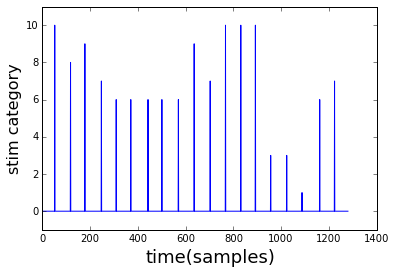

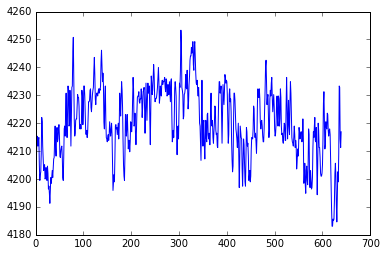

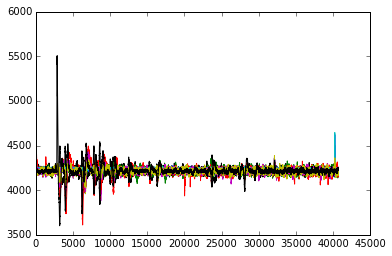

In [115]:
# let's visualize some of the varibales we have:

# let's see the triggers
plt.plot(stim_triggs[0:fs*10])
plt.ylim([-1, 11])
plt.xlabel('time(samples)', fontsize=18)
plt.ylabel('stim category', fontsize=16)
plt.show()

# let's see a single channel of eeg for 4 seconds
plt.plot(raw_data[5,0:fs*5])
plt.show()

# plot all EEG channels
plt.plot(raw_data[0:14].T)
plt.show()

 Lets check the offset of channel 1, which is:  4213.84619140625000000000


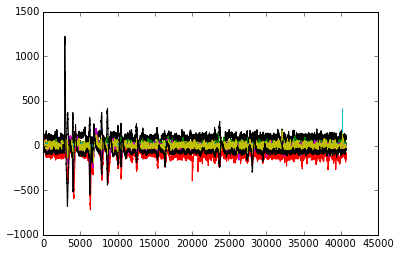

In [111]:
# we will remove the DC bias from all channels

print ' Lets check the offset of channel 1, which is:', raw_data[0,0]

# the csv file throws a data with a type of 'string', and here we cast it to be a float
raw_data = raw_data.astype(np.float)

# let's create a matrix where we will store the data without an offset:
raw_data_no_offset = np.zeros(raw_data.shape)

# remove the offset
for channel in range(14):
    raw_data_no_offset[channel, :] = raw_data[channel,:] - raw_data[channel,0]

# let's see the data
plt.plot(raw_data_no_offset.T)
plt.show()

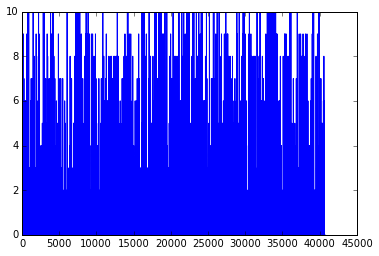

the shape of stim_idx is:  (1, 625)
The first 30 indices where stimli arrive are:  [  53  119  179  248  310  371  443  501  570  636  703  767  831  892  956
 1023 1087 1161 1223 1290 1358 1422 1488 1554 1626 1687 1757 1824 1891 1955]


In [116]:
# let's epoch the data

# first,let's identify where the stimuli are
# as a first approximation, let's plot the stim channel

# let's just plot the first 10 seconds
plt.plot(stim_triggs)
plt.show()
# we need to zoom in to the samples where the entry and exit of stimuli 
# becomes more visually eident

# change this to be float
stim_triggs = stim_triggs.astype(np.float)

# let's isolate the indices where the triggers come in
stim_idx = np.asarray(np.where(stim_triggs > 0))

print 'the shape of stim_idx is: ', stim_idx.shape
print 'The first 30 indices where stimli arrive are: ', stim_idx[0,0:30]

In [117]:
# we know that the data has shape raw_data_no_offset.shape

# the first thing we should do, is to count how many stim we have!
stim_list = []
for index in range(1,stim_idx.shape[1]):
    if stim_idx[0,index] > (stim_idx[0,index-1]+5):
        stim_list.append(stim_idx[0,index])
        
stim_count = len(stim_list)

print 'The shape of stim_list is: ', type(stim_list)
print 'The indices for the first 10 stim are: ', stim_list[0:10]
print stim_count

The shape of stim_list is:  <type 'list'>
The indices for the first 10 stim are:  [119, 179, 248, 310, 371, 443, 501, 570, 636, 703]
624


In [118]:
# now we will finally epoch the data

# we pick these parameters based on what we want to see in the data
pre_stim = 10
post_stim = 50

epoched_data = np.zeros([nchan,stim_count,pre_stim+post_stim])

# ignore the last stimulus
del stim_list[-1]

for stim_num, stim in enumerate(stim_list):
#     print raw_data_no_offset[0:nchan,(stim-pre_stim):(stim+post_stim)].shape
    epoched_data[:,stim_num,:] = raw_data_no_offset[0:nchan,(stim-pre_stim):(stim+post_stim)]

Plotting data for channel  3  and epoch number  391
Dimensions before squeezing: (60,)
Dimensions after squeezing: (60,)


/Users/iranroman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  app.launch_new_instance()
/Users/iranroman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 624 + 1) instead


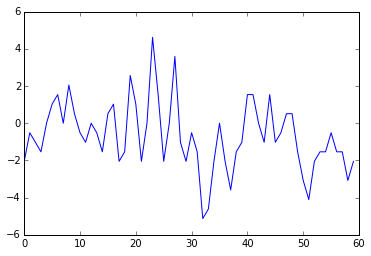

In [121]:
# sanity check, let's plot some datapoints

rand_chan = np.random.random_integers(nchan)
rand_epoch = np.random.random_integers(stim_count)

print 'Plotting data for channel ', rand_chan, ' and epoch number ', rand_epoch 

print 'Dimensions before squeezing:', epoched_data[rand_chan,rand_epoch,:].shape
print 'Dimensions after squeezing:', np.squeeze(epoched_data[rand_chan,rand_epoch,:]).shape

plt.plot(epoched_data[rand_chan,rand_epoch,:])
plt.show()

In [122]:
# The next step, is to rmove the DC offset from each one of our epochs

# we have a stimulus, arriving at 200 ms into our epoch. All epochs have a DC offset associated with it
# we want DC to be 0 at the time that the stim came in. Therefore, grab a window of 20 ms before the
# actual onset of the stimulus, average the values in this window, and remove that DC component from the 
# entire epoch.

stim_arrival = 10

baseline_period = range(5,10)

epoched_data_basel_corr = np.zeros(epoched_data.shape)

for chan in range(nchan):
    for epoch in range(epoched_data.shape[1]):
        epoched_data_basel_corr[chan,epoch,:] = epoched_data[chan,epoch,:] - np.mean(epoched_data[chan,epoch,baseline_period])

Plotting data for channel  12  and epoch number  1


/Users/iranroman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  app.launch_new_instance()
/Users/iranroman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 624 + 1) instead


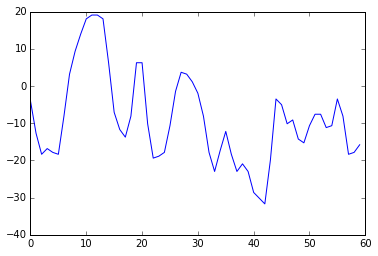

In [127]:
# sanity check, let's plot some datapoints

rand_chan = np.random.random_integers(nchan)
rand_epoch = np.random.random_integers(stim_count)

print 'Plotting data for channel ', rand_chan, ' and epoch number ', rand_epoch 
plt.plot(epoched_data_basel_corr[rand_chan,rand_epoch,:])
plt.show()

In [128]:
# Now we will eliminate noisy stimuli trials, by cancelling trials with absolute amplitudes greater than 100

amp_limit = 100

bad_epoch_idx = [] 

# print epoched_data_basel_corr[1:10,epoch,1:10]

# we will iterate over all the epochs, which are one of the dimensions in our matrix
# and we will look at all the samples and all the channels simultaneously
for epoch in range(epoched_data_basel_corr.shape[1]):
    
    if np.max(np.abs(epoched_data_basel_corr[:,epoch,:])) > amp_limit:
        bad_epoch_idx.append(epoch)
                    
clean_epoched_data = epoched_data_basel_corr
            
clean_epoched_data = np.delete(clean_epoched_data, np.asarray(bad_epoch_idx), 1)

print 'The shape of epoched_data_basel_corr is:', epoched_data_basel_corr.shape 
print 'The shape of clean_epoched_data is:', clean_epoched_data.shape 


The shape of epoched_data_basel_corr is: (14, 624, 60)
The shape of clean_epoched_data is: (14, 561, 60)


This is the ERP as recorded from one electrode


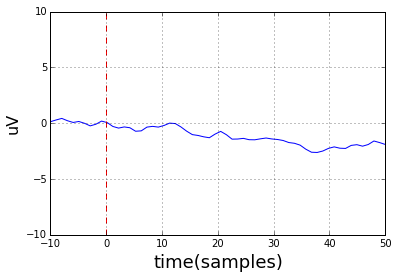

In [132]:
# WE HAVE ARRIVED! This is the finishline

ERPs = np.mean(clean_epoched_data, axis=1)

print 'This is the ERP as recorded from one electrode'
            
elec = 13

# this time linspace, will help us plot the x axis, as starting 200 ms before the onset of the stimulus, which is at 0
time = np.linspace(-10,50,60)

plt.plot(time,ERPs[elec,:])
plt.xlim([-10,50])
plt.ylim([-10,10])
plt.xlabel('time(samples)', fontsize=18)
plt.ylabel('uV', fontsize=16)
plt.plot((0, 0), (-10, 10), 'r--')
plt.grid()
plt.show()  

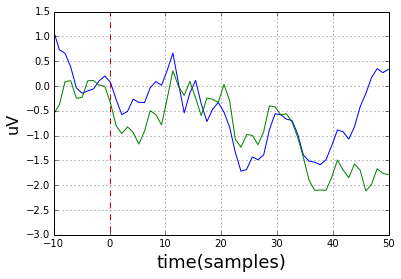

In [138]:
# let's look at all the electrodes at once!

plt.plot(time,ERPs[1:3].T)
plt.xlim([-10,50])
plt.ylim([-3,1.5])
plt.xlabel('time(samples)', fontsize=18)
plt.ylabel('uV', fontsize=16)
plt.plot((0, 0), (-10, 10), 'r--')
plt.grid()
plt.show()  